# **Business case 3: Anomaly Detection**
The idea that almost entirely drove our project was to evaluate the performance of the anomaly detection model through a practical, business-oriented approach. As a matter of fact, a labeled test set obtained by fractioning the original dataset would contain roughly 100 to 200 samples. Since the number of anomalies is, in general, much smaller than the number of normal data, even one misclassified anomaly would change drastically the performance of the model. For this reason, two important decisions were taken:
- Multiple anomaly detection techniques based on completely different approaches were implemented. The best models were put together to form a single, more powerful model by means of model averaging. This allowed to exploit the advantages of each specific architecture (providing diversification) and to average out the errors of each model;
- The predictions of the anomaly detection model on additional unlabeled data were used to regulate the risk-propensity of a toy portfolio (i.e. the fraction of equites, bonds and commodities forming the portfolio). Our custom portfolio outperformed three different benchmarks (low, medium and high risk), revealing the goodness of the model.

### Setup

Importing libraries and setting the Google Drive directory.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import random
import warnings
import os
import sys

from keras import backend as K
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from pyod.models.copod import COPOD


tfk = tf.keras
tfkl = tf.keras.layers
seed = 33
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
# Setting the directory in the shared Google Drive folder when using Google Colab
# drive.mount('/gdrive')
# %cd "/gdrive/MyDrive/Colab Notebooks/Fintech/Business Case 3"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1M7onH0tJVSSuWKEB3HTIpuTn_T_EkF6r/Fintech/Business Case 3


# Data Preprocessing and Exploration

### Data Exploration

Considering the entire dataset, three main groups can be identified, corresponding to interest rates (center), currencies (left), and currency indices (right).

In [ ]:
# Reading dataframe from excel file
df = pd.read_excel('FinancialMarketData.xlsx', 'EWS')
df.head()

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,2000-01-11,283.25,0.077,1388,157.26,100.56,105.86,1.6460,25.77,...,116.4635,230.5267,123.7616,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,2000-01-18,287.65,0.043,1405,165.01,101.86,105.47,1.6383,28.85,...,117.2674,231.3770,123.7616,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,2000-01-25,287.15,0.135,1368,167.24,102.41,106.04,1.6496,28.28,...,117.9946,232.3895,123.7616,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2000-02-01,282.75,0.191,1311,166.85,104.92,107.85,1.6106,28.22,...,120.5100,231.9417,122.3281,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2000-02-08,298.40,0.312,1277,165.43,104.22,109.30,1.6108,28.02,...,118.7914,237.8117,122.3281,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


<Axes: >

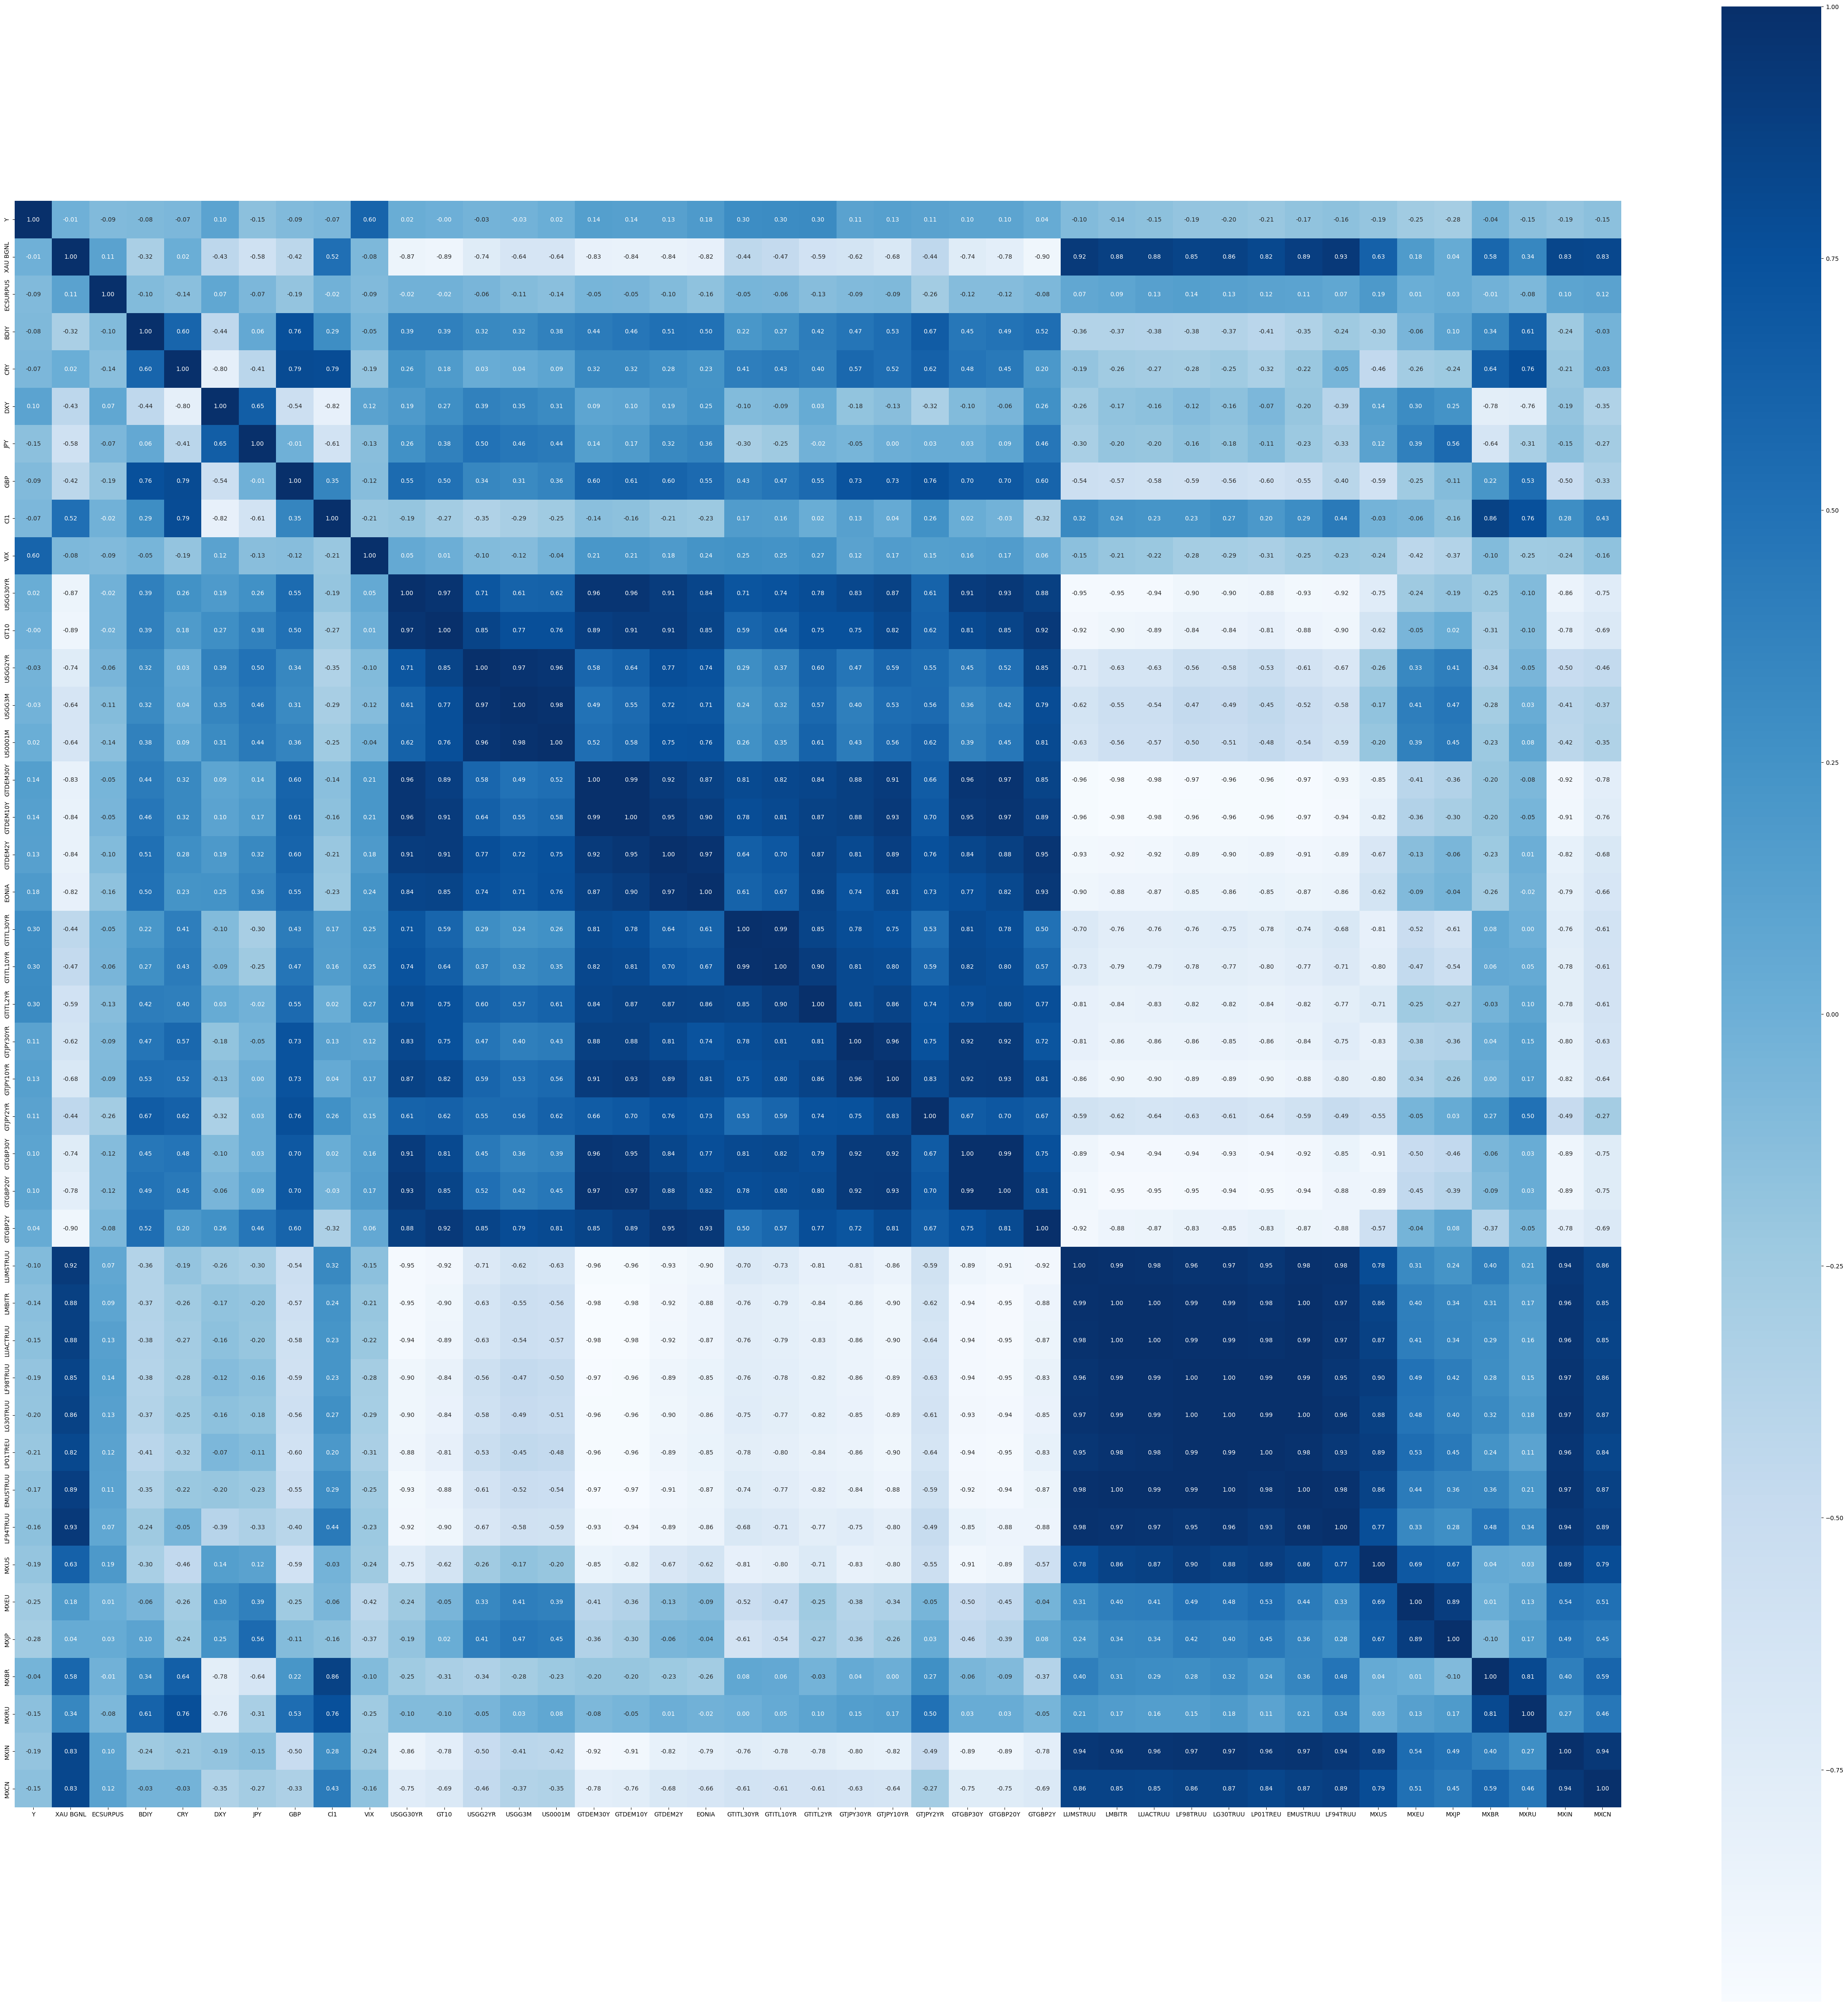

In [ ]:
# plot the correlation matrix
df1=df
df1.drop(labels = 'Data', axis = 1, inplace = True)
#df1.drop(labels = 'Y', axis = 1, inplace = True)
corrmat = df1.corr()
plt.figure(figsize=(60, 60))
sns.heatmap(corrmat,
            cbar=True,
            annot=True,
            square=True,
            cmap="Blues",
            fmt='.2f',
            annot_kws={'size': 10},
            yticklabels=df1.columns,
            xticklabels=df1.columns)

In [ ]:
def FindCorrFeature(X):
  corr_features = set()
  for i in range(len(X.columns)):
    for j in range(i):
        if abs(X.iloc[i, j]) > 0.9:
            col = X.columns[i]
            corr_features.add(col)
            col2 = X.columns[j]
            corr_features.add(col2)

  return corr_features

In [ ]:
correlated_features= FindCorrFeature(corrmat)
print(correlated_features)

{'MXIN', 'US0001M', 'LUACTRUU', 'LUMSTRUU', 'LF94TRUU', 'EONIA', 'LG30TRUU', 'GTDEM2Y', 'USGG2YR', 'USGG30YR', 'MXCN', 'GTJPY10YR', 'GTITL10YR', 'GTITL30YR', 'LP01TREU', 'LF98TRUU', 'LMBITR', 'GTGBP2Y', 'GTGBP20Y', 'GTDEM30Y', 'EMUSTRUU', 'GTITL2YR', 'MXUS', 'GT10', 'XAU BGNL', 'GTJPY30YR', 'USGG3M', 'GTGBP30Y', 'GTDEM10Y'}


### Data Preprocessing

In light of data exploration results, we operate the following changes to the original dataset:
- We add a new feature SP_GOLD defined as S&P 500/XAU BGNL. S&P 500 is often seen as a benchmark for the overall health of the U.S. stock market and is considered a measure of risk appetite. During periods of positive market sentiment and investor confidence, stock prices tend to rise, leading to an increase in the value of the S&P 500. Gold (XAU BGNL), on the other hand, is often seen as a store of value during times of economic uncertainty or market volatility. The S&P 500/Gold ratio combines these two indicators into a single metric, providing a relative measure of risk appetite in the market. When the ratio is rising, it suggests that the stock market is outperforming gold, indicating a risk-on sentiment.
- We transform not-index and not-label data into **weekly returns**. This operation not only rescales data of different features to have similar values, but also allows to obtain stationary data.

- We discard some features based on two criteria: we remove the features with high degree of correlation and the redundant assets, namely the features that provide the same information.
We keep only the following:
  - Cl1:  it can help identify patterns within the commodity market.
  - MXCN, MXEU, MXJP, MXUS: they all refer to different stock markets (China, Europe, Japan, USA) and sudden changes in their values could indicate potential anomalies in the corresponding markets.
  - VIX: it measures the market's expectation of volatility based on options contracts. Anomalous spikes can be indicative of market uncertainty, panic, or significant events.
  - GT10: (10-year Treasury yield) Monitoring it can provide insights into abnormal shifts in the bond market.
  - ECSURPUS:  within the insurance industry, monitoring the ECSURPUS can help identify abnormal changes or fluctuations in the surplus capital, which may indicate potential financial risks, or unusual investment behavior
  - SP_GOLD: described previously.

  In a nutshell, these features can provide valuable insights into different aspects of the financial markets, including patterns, market sentiment, volatility, bond market conditions, and insurance industry risks.


- We split the original dataset into training and validation sets according to <code>train_fraction</code>, which is set to $0.8$ by default. We decided to not implement a test set because we wanted to test the model on recent Bloomberg data (2021-2023) and exploit model results to build a toy portfolio.

- We normalized training set and validation set (using training set normalization parameters).

In [ ]:
# This function adds the SP_GOLD feature to the dataset
def add_sp_gold(df):

    # INPUTS:
    # df: dataset dataframe

    # OUTPUTS:
    # df: dataset dataframe with SP_GOLD feature added

    # Defining starting (first row) and ending (last row) dates to download data from yfinance
    start_date = str(df['Data'][0])[:10]
    end_date = str(df['Data'][df.shape[0]-1])[:10]

    # Downloading 'close' data from yfinance
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1wk')
    sp500 = sp500['Close']

    # Defining the new feature SP500/GOLD and renaming the column
    sp500_gold = pd.DataFrame(sp500.to_numpy() / df['XAU BGNL'].to_numpy())
    sp500_gold.columns = ['SP_GOLD']

    # Concatenating the new feature to the original dataframe
    df = pd.concat([df, sp500_gold], axis=1)

    return df



# This function transforms non-index and non-label data into weekly returns
def compute_returns(df):

    # INPUTS:
    # df: dataset dataframe

    # OUTPUTS:
    # df: dataset dataframe with returns-converted columns

    # These are the features which have to be transformed
    returns_labels = ['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXUS', 'VIX', 'GT10']
    returns_features = df[returns_labels].to_numpy()

    # Calculating the returns as the differences between feature at time t and time t-1, divided by feature at time t-1 (times 100)
    returns = pd.DataFrame(np.diff(returns_features, axis=0) / returns_features[:-1, :]) * 100

    # Restoring the original column names and indexes
    returns.columns = returns_labels
    returns.index = df.index[1:]

    # Defining the new dataset as concatenation of the new, transformed features and the untouched ones
    df_new = pd.concat([returns, df[['SP_GOLD', 'ECSURPUS', 'Y']].iloc[1:]], axis=1)

    return df_new



# This function splits the dataset into training and validation sets according to train_fracion
def train_val_split(df, train_fraction = 0.8):

    # INPUTS:
    # df            : original dataset dataframe
    # train_fraction: fraction of data going into the training set (default is 0.8)

    # OUTPUTS:
    # train_df      : training dataset consisting of first (df.shape[0]*train_fraction) samples
    # val_df        : validation dataset consisting of last (df.shape[0]*(1-train_fraction)) samples

    split_index = int(df.shape[0]*train_fraction)
    train_df = df.iloc[:split_index]
    val_df = df.iloc[split_index:]

    return train_df, val_df



# This function normalizes training dataframe and uses the feature-wise means and standard deviations
# to normalize also the validation set (exploiting only the knowledge on the training set)
def scaler(t_df, v_df, scaling='Standard'):

    # INPUTS:
    # t_df    : non-normalized training set
    # v_df    : non-normalized validation set
    # scaling : if scaling='MinMax' then minmax scaling is applied, otherwise standard scaling is applied

    # OUTPUTS:
    # train_df: normalized training set
    # val_df  : normalized validation set

    # Defining new dataframe copies to work with in order to not modify the original ones
    train_df = t_df.copy()
    val_df = v_df.copy()

    columns = list(train_df.columns)
    columns.remove('Y')

    # If 'minmax' scaling is specified when calling the function, minmax scaling is applied to the data
    if scaling.upper() == 'MINMAX':
        for c in columns:
            min = np.min(train_df[c])
            max = np.max(train_df[c])
            train_df[c] = (train_df[c]-min)/(max-min)
            # To scale the data contained in the validation set we still use the minimum and the maximum
            # of the data in the training set, since we should not exploit the knowledge of validation set data
            val_df[c] = (val_df[c]-min)/(max-min)
        print('MinMax scaling was applied')

    # If nothing or something different from 'minmax' is specified, standard scaling is applied
    else:
        for c in columns:
            mean = np.mean(train_df[c])
            std = np.std(train_df[c])
            train_df[c] = (train_df[c]-mean)/(std)
            val_df[c] = (val_df[c]-mean)/(std)
        print('Standard scaling was applied')

        if scaling.upper() != 'STANDARD':
            print('Inserted option was not available')

    return train_df, val_df

In [ ]:
# Reading dataframe from excel file
df = pd.read_excel('FinancialMarketData.xlsx', 'EWS')

# Adding sp_gold column to dataframe
df_sp_gold = add_sp_gold(df)

# Cutting out unnecessary features
reduced_df = df_sp_gold[['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXRU', 'MXUS', 'VIX', 'GT10', 'ECSURPUS', 'SP_GOLD', 'Y']]

# Computing returns for non-index, non_label features
returns_df = compute_returns(reduced_df)

# Splitting the dataframe into training and validation sets
train_df, val_df = train_val_split(returns_df)

# Normalize the data
train_df_norm, val_df_norm = scaler(train_df, val_df)

[*********************100%***********************]  1 of 1 completed
Standard scaling was applied


In [ ]:
# Separating input data from labels
x_train = train_df_norm.drop(labels = 'Y', axis = 1)
x_val = val_df_norm.drop(labels = 'Y', axis = 1)
y_train = train_df_norm['Y']
y_val = val_df_norm['Y']

### Stationarity Tests

Exploiting statistical analysis methods to explore the stationarity of our dataset:

In [ ]:
names = train_df.columns.to_numpy()

for i in range(len(train_df.columns)):
    x=train_df[names[i]]
    adf_test=adfuller(x)
    print(names[i],adf_test[1])

Cl1 1.0549929772537865e-13
MXCN 2.7286400424657384e-17
MXEU 0.0
MXJP 0.0
MXUS 8.227163542291652e-30
VIX 1.6823857051125292e-19
GT10 1.229028417983219e-24
SP_GOLD 0.029114905701939805
ECSURPUS 1.1175212272211647e-07
Y 1.159086155809974e-06


The stationarity of the return series is examined by considering the Augmented Dickey-Fuller (ADF) test. The results shows that the hypothesis of a Unit Root can be rejected at the 5% level of significance; thus data stationarity follows.

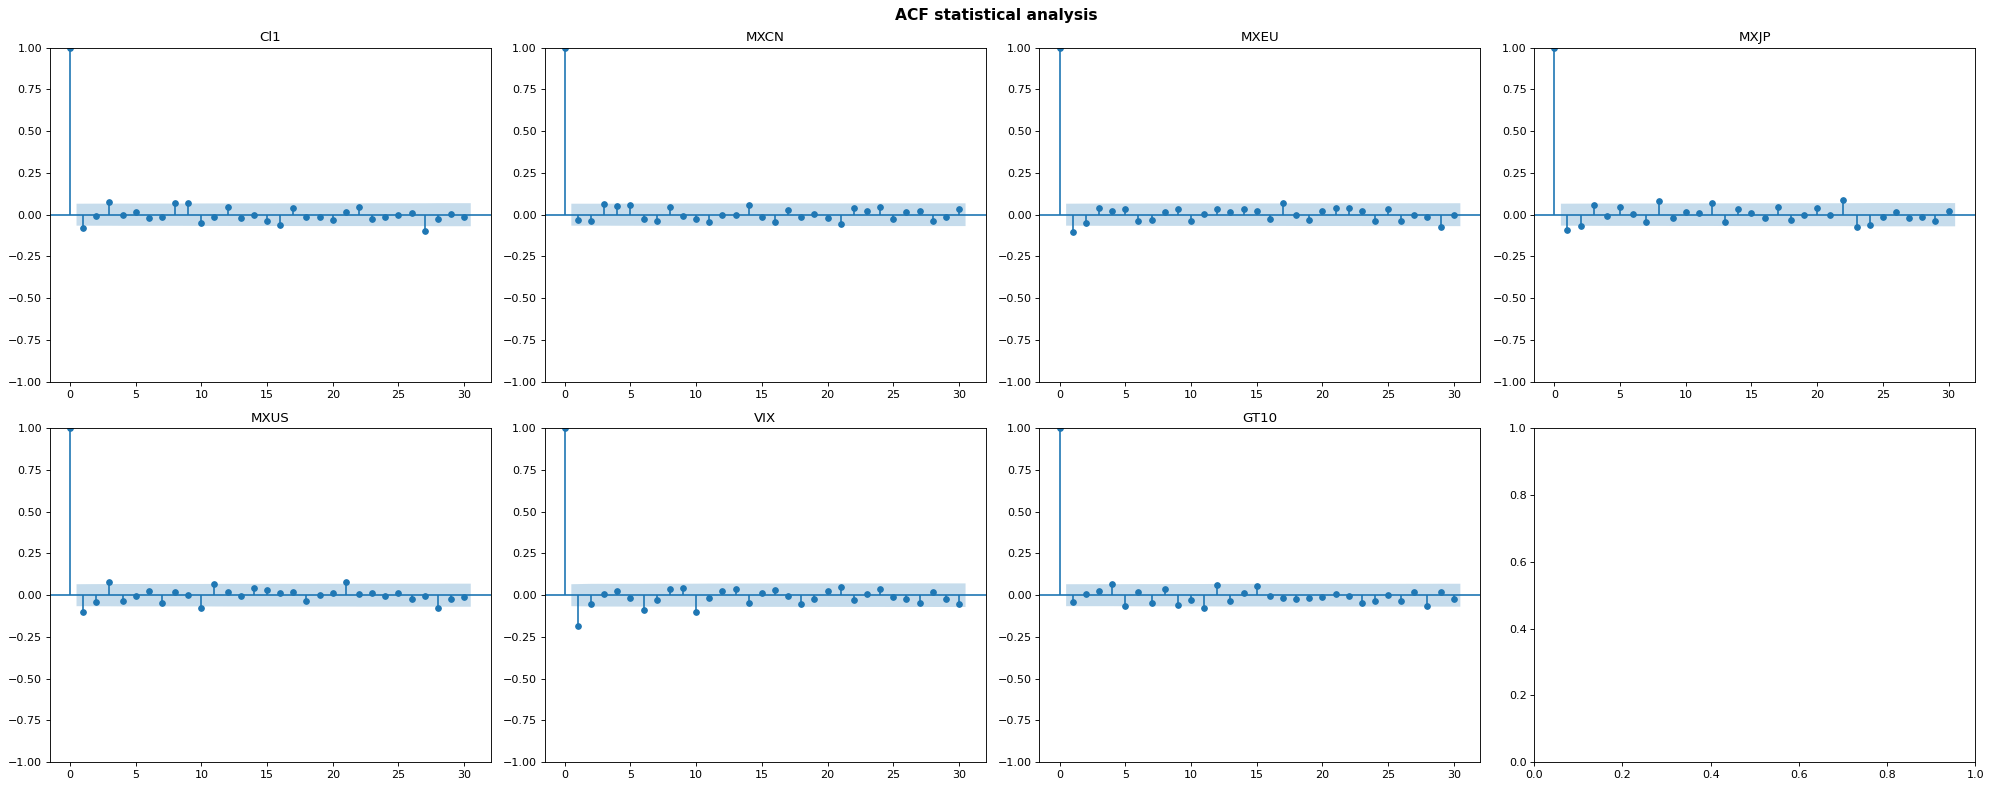

In [ ]:
# ACF statistical analysis for each feature that is not an index
row = 0
column = 0
cont=0
max_rows = 2
max_columns = 4
fig, axes = plt.subplots(max_rows, max_columns, figsize=(25, 10), dpi=80)
fig.suptitle('ACF statistical analysis', fontsize=14, fontweight='bold')


for i in range(len(train_df.columns)):
    cont=cont +1
    x = train_df[names[i]]
    ax = axes[row][column]

    tsaplots.plot_acf(x, lags=30, title=names[i], ax=ax)

    column = column + 1
    if column % max_columns == 0:
        column = 0
        row = row + 1

    if row >= max_rows or column >= max_columns:
        break

    if cont >6:
      break

plt.tight_layout()
plt.show()

The Autocorrelation Function plot demonstrates how the autocorrelation value of simple returns falls within the 95% confidence bands after the first lag, thus indicating the absence of autocorrelation.

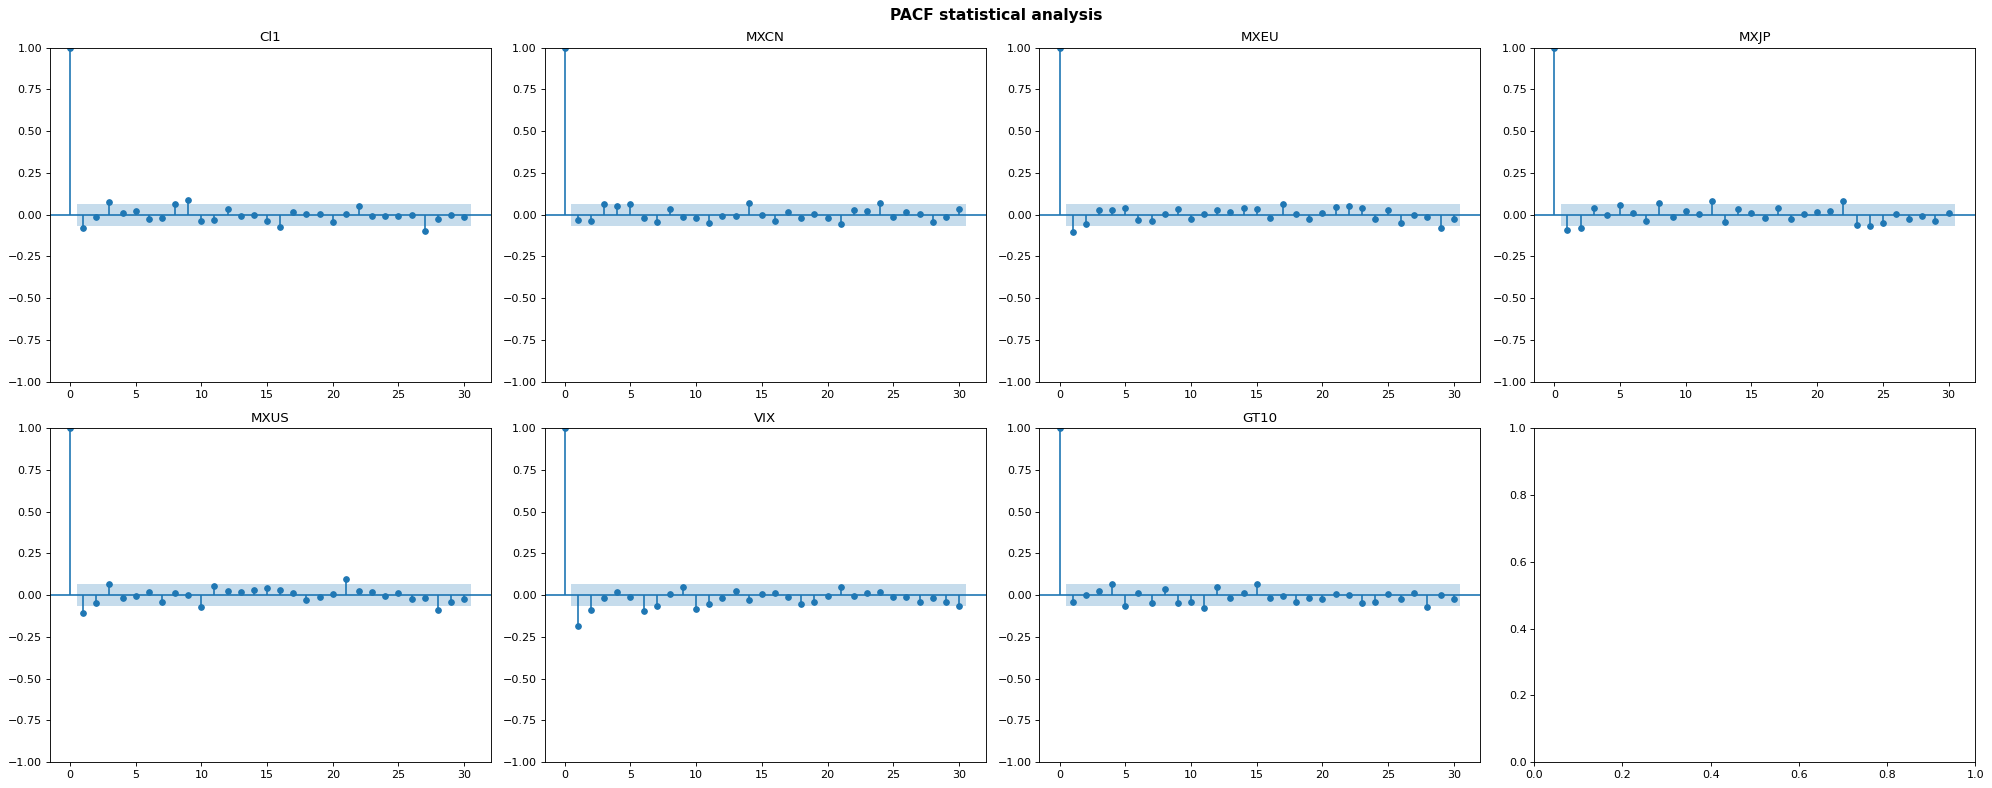

In [ ]:
# PACF statistical analysis for each feature that is not an index

row = 0
column = 0
cont=0
max_rows = 2
max_columns = 4
fig, axes = plt.subplots(max_rows, max_columns, figsize=(25, 10), dpi=80)
fig.suptitle('PACF statistical analysis', fontsize=14, fontweight='bold')


for i in range(len(train_df.columns)):
    cont=cont+1
    x = train_df[names[i]]
    ax = axes[row][column]

    tsaplots.plot_pacf(x, lags=30, title=names[i], ax=ax)

    column = column + 1
    if column % max_columns == 0:
        column = 0
        row = row + 1

    if row >= max_rows or column >= max_columns:
        break
    if cont >6:
      break

plt.tight_layout()
plt.show()

The Partial Autocorrelation Function plot suggests that no autoregressive behaviour is present in the time series because the only significant lags are meaningless from a financial perspective. Thus, combining the information from the ACF and PACF plots, we can conclude that the mean structure of the returns does not show an ARMA behaviour.

# Anomaly Detection

The main idea of the anomaly detection part of the project was to try out several different techniques and exploit **ensamble averaging** on the best performing models. In this way the various errors of the models could be "averaged out" obtaining an ensamble of models which performs better than the individual ones.

These are the models that have been tried out:
- **Support Vector Machines**:  SVM is a supervised learning algorithm which works by finding an optimal hyperplane that separates the data points into different classes, maximizing the margin between the classes. SVM can be used for anomaly detection by treating the problem as a binary classification problem, and can handle nonlinearities by using different kernel functions.

- **Long Short-Term Memory**: LSTM is a type of recurrent neural network architecture designed to model sequential data and capture long-term dependencies in the input data, making it effective for tasks like time series analysis and speech recognition. LSTM can be used for anomaly detection by treating the problem as a binary classification problem (the details will be discussed in the LSTM section).

- **Autoencoder**: Autoencoders are neural network architectures consisting of an encoder and a decoder network. The encoder compresses the input data into a lower-dimensional representation, while the decoder aims to reconstruct the original input from this encoding. Autoencoders can be used for anomaly detection applications by training the model on "normal" data only and using it to reconstruct data points. The autoencoder learns to reconstruct the normal data accurately, and when presented with anomalous data it fails to reconstruct it properly, resulting in a higher reconstruction error.

- **Copula**: Copula is a statistical tool used for modeling the dependence structure between random variables. Copulas can be used for anomaly detection by modeling the dependence structure between variables and identifying data points that deviate significantly from the learned dependency patterns.

- **Random Forest**: Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It creates a collection of decision trees and aggregates their predictions to obtain the final result. Random Forest, like SVM and LSTM, can deal with the anomaly detection problem by treating it as a binary classification problem. Several combinations of parameters were tried out in order to obtain the best possible architecture to deal with the anomaly detection problem. This model was not included in the ensamble averaging because of its poor performance on our dataset with respect to other methods.

- **Transformer**: The Transformer is a neural network architecture that has gained significant popularity in natural language processing tasks, especially machine translation. It utilizes a self-attention mechanism, enabling it to capture relationships between words in a sentence without relying on sequential processing. Transformers can be used for anomaly detection by leveraging their ability to model sequential and contextual information in data in an autoencoder fashion (encoder + decoder). Since transformers are data hungry and require a huge amount of samples for training, training a model from scrath with our dataset was not an option. The group tried to implement a pre-trained model from Hugging Face (https://huggingface.co/docs/transformers/model_doc/time_series_transformer) without achieving noteworthy results.

### Support Vector Machines

With SVM we treat the problem as a binary classification problem (0 is the "normal" class, 1 is the "anomaly" class). The following list describes the parameter selection procedure for SVM:
- <code>kernel</code>: This is the base used to determine the hyperplane boundary between classes. Linear and radial basis function (rbf) kernels were tried out, and we expected to get better results with rbf kernel because of the capability to handle nonlinear dependencies in input data.
- <code>gamma</code>: This parameter determines the shape of the decision boundary and the flexibility of the SVM model. A low value of $\gamma$ makes the decision boundary smoother and more generalized, while a high value of $\gamma$ leads to a more complex and tightly fitted decision boundary. Different values of $\gamma$ were tested, but the default one seemed to yield good results.
- <code>C</code>: This parameter determines the amount of L2 regularization (inversely proportional to <code>C</code>). As for the $\gamma$ case, the default value yielded good results.
- <code>class_weight</code>: This parameter determines the weight given to each class during training. Since the dataset is heavily unbalanced (i.e. there are much more normal samples than anomaly samples), larger wwight to anomaly samples should lead to better performances. The ratio <code>w</code> between anomaly and normal class weights was determined by maximizing the cross-validation recall metric (10-fold split).

In [ ]:
# Initializing the 'best recall' value
best_recall = 0

# Specifying possible values of the weights for the anomalies class
min_w = 1
max_w = 5
step_w = 0.5

# Similarly to the RF case:
# Looping through the possible weight values and running SVM algorithm for each combination of the parameters.
# If the recall metric obtained through cross-validation is higher than the current best recall, then the optimal weight value is stored
for w in np.arange(min_w, max_w, step_w):

    # Creating an SVM classifier with a linear kernel and specified class weights
    svm_linear = svm.SVC(kernel='linear', class_weight={0:1, 1:w}, random_state=seed)
    svm_linear.fit(x_train, y_train)

    # Using cross-validation to predict the target variable with the linear kernel SVM
    y_pred_linear = cross_val_predict(svm_linear, x_train, y_train, cv = 10)

    # Calculating the recall score of the predicted values
    recall = recall_score(y_train, y_pred_linear)

    # Updating recall and optimal weights if current recall is higher than previous best recall
    if recall > best_recall:
        best_recall = recall
        linear_w = w

# Displaying the best recall and optimal weight for the linear kernel SVM
print(f'Linear Kernel recall: {best_recall}')
print(f'Linear Kernel weight: {linear_w:.1f}')

# Repeating the same procedure for 'radial basis function' kernel instead of 'linear' kernel
best_recall = 0

for w in np.arange(min_w, max_w, step_w):

    # Creating an SVM classifier with a radial basis function kernel and specified class weights
    svm_rbf = svm.SVC(kernel='rbf', class_weight={0:1, 1:w}, random_state=seed)
    svm_rbf.fit(x_train, y_train)

    # Using cross-validation to predict the target variable with the radial basis function kernel SVM
    y_pred_rbf = cross_val_predict(svm_rbf, x_train, y_train, cv = 10)

    # Calculating the recall score of the predicted values
    recall = recall_score(y_train, y_pred_rbf)

    # Updating recall and optimal weights if current recall is higher than previous best recall
    if recall > best_recall:
        best_recall = recall
        rbf_w = w

# Displaying the best recall and optimal weight for the radial basis function kernel SVM
print(f'Radial Basis Funciton Kernel recall: {best_recall:.4f}')
print(f'Radial Basis Function Kernel weight: {rbf_w:.1f}')

Linear Kernel recall: 0.6826923076923077
Linear Kernel weight: 4.5
Radial Basis Funciton Kernel recall: 0.6683
Radial Basis Function Kernel weight: 4.5


Computing predictions using the best weights for both the radial basis function and linear kernels.

In [ ]:
# SVM classifier with linear kernel and best weight value
svm_linear = svm.SVC(kernel='linear', class_weight={0:1, 1:linear_w}, random_state=seed)
svm_linear.fit(x_train, y_train)

# Predicting the target variable using the linear kernel SVM
y_pred_linear = svm_linear.predict(x_val)

# SVM classifier with radial basis function kernel and best weight value
svm_rbf = svm.SVC(kernel='rbf', class_weight={0:1, 1:rbf_w}, random_state=seed)
svm_rbf.fit(x_train, y_train)

# Predicting the target variable using the radial basis function kernel SVM
y_pred_rbf = svm_rbf.predict(x_val)

# Storing the predictions and F1 score for later use
res_svm = y_pred_rbf
f1_score_SVM = f1_score(y_val, y_pred_rbf)

Computing the confusion matrices for the two kernels and defining the values that will be contained in the confusion matrix plots.

In [ ]:
# List of titles for the confusion matrix plots
title = ['Linear Kernel', 'Radial Basis Function Kernel']

# Looping through the predictions and corresponding indices for the linear and radial basis function kernels
for y_pred, i in zip([y_pred_linear, y_pred_rbf], [0, 1]):

    # Computing the confusion matrix and normalizing it to percentages
    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    # Defining the group names and percentages for the confusion matrix plot
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Printing the metrics for the current kernel
    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')

    # Printing the values for the confusion matrix
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')

    if i==0: print('\n')

Linear Kernel metrics:
Accuracy:	0.450
Recall:		0.483
Precision:	0.116
F1score:	0.187
True Neg:	6.31%
False Pos:	6.76%
False Neg:	48.20%
True Pos:	38.74%


Radial Basis Function Kernel metrics:
Accuracy:	0.874
Recall:		0.552
Precision:	0.516
F1score:	0.533
True Neg:	7.21%
False Pos:	5.86%
False Neg:	6.76%
True Pos:	80.18%


Plotting the two confusion matrices.

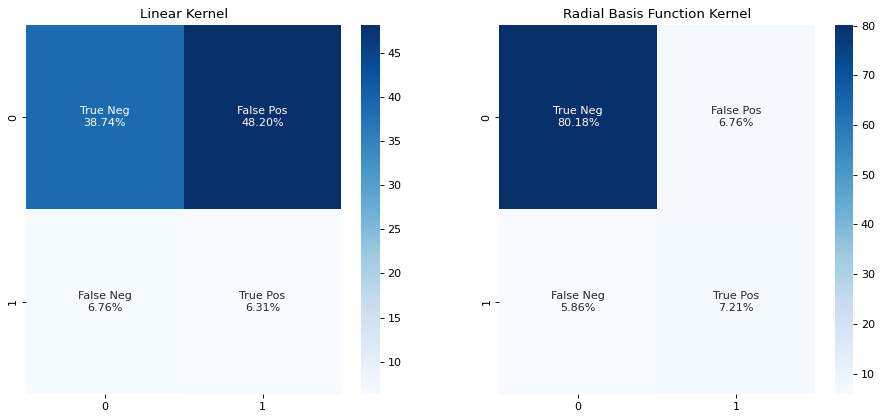

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)

# Looping through the predictions and corresponding indices for the linear and radial basis function kernels
for y_pred, i in zip([y_pred_linear, y_pred_rbf], [0, 1]):

    # Computing the confusion matrix and normalizing it to percentages
    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[0, 1], sample_weight=None) / len(y_pred) * 100)

    # Defining the group names and percentages for the confusion matrix plot
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Creating a heatmap of the confusion matrix using seaborn
    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')

    # Setting the title for the subplot based on the current kernel
    axes[i].set_title(title[i])

### LSTM

LSTM architecture is designed to capture long-term dependencies in sequential data. Financial time series data exhibit complex patterns and dependencies that evolve over time. LSTM's recurrent structure allows it to retain information about past observations and learn the temporal relationships between data points. This theoretically enables it to model the dynamics of financial time series and identify anomalies.

There are several ways to implement an LSTM architecture in this case study. The two main approaches are:
- **many to many**: the input of the network is a time series of $W$ time steps and the output is a sequence of $W$ labels. In this way we assign a label for each time step of the input sequence, and to determine the labels of later time steps the network exploits the information from previous time steps.
- **many to one**: the input of the network is a time series of $W$ time steps and the output is a single label. With this approach we train the network to learn only the label related to the last time step of the sequence: given a sequence, the network should exploit the information of previous weekly data to determine the label of the last week seen.

The *many to one* approach yielded the best results in terms of F1 score with respect to the other methods, and it is the one presented below. Training (validation) pairs are built from <code>x_train</code> and <code>y_train</code> (<code>x_val</code> and <code>y_val</code>) using a sliding window of dimension <code>W=50</code> (it is the one which yielded best results) and associating to each window the label related to the last time step of the window.

In [ ]:
# This is the dimension of the window, which determines how much the network is able to look backward
# (in terms of number of time steps) in order to correctly classify the last time step of the series.
WINDOW = 50

# Function which prepares data in order to feed it to the LSTM network. Data is divided into windows
# (which are 'WINDOW' timestamps long) and reshaped into a ('samples', 'WINDOW', 'features') dimensional tensor.
def build_LSTM_samples(x, y, W=50):

  # INPUT:
  # x    : numpy array of training/validation samples (e.g. x_train.to_numpy())
  # y    : numpy array of training/validation labels (e.g. y_train.to_numpy())

  # OUPUT:
  # x_new: numpy array of training/validation samples split into windows
  # y_new: numpy array of training/validation labels (each label is associated to a window)

  samples = x.shape[0]
  features = x.shape[1]

  # defining the shape of the output data tensor
  x_new = np.empty((samples-W+1, W, features))

  # inserting the windows into the new data vector through looping and indexing
  for i in range(x_new.shape[0]):
    x_new[i] = x[i:i+W]

  # reshaping also the labels (the first W-1 labels are discarded)
  y_new = y[W-1:].reshape(y[W-1:].shape[0])

  return x_new, y_new



# Function to calculate recall
def recall(y_true, y_pred):

  # INPUT:
  # y_true: numpy array of true labels
  # y_pred: numpy array of predicted labels

  # OUPUT:
  # recall: recall metric related to y_true and y_pred

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall



# Function to calculate F1 score
def f1score(y_true, y_pred):

  # INPUT:
  # y_true : numpy array of true labels
  # y_pred : numpy array of predicted labels

  # OUPUT:
  # f1score: f1 score metric related to y_true and y_pred

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
  return f1_score

Since we do not want to lose <code>WINDOW-1</code> validation samples due to how <code>build_samples</code> function is designed (it discards the first <code>WINDOW-1</code> labels), we use the last part of the training instances to build the <em>'windowed'</em> validation set. This can be done because the samples are not shuffled and the validation set samples are exactly subsequent to the training set ones. Also, since we are not including any training labels into the validation set, we are not "cheating" by including training information in the validation set.

In [ ]:
# Creating training instances using build_samples function
x_train_window, y_train_window = build_LSTM_samples(x_train.to_numpy(), y_train.to_numpy(), WINDOW)

# Creating validation instances using build_samples function
x_val_window, y_val_window = build_LSTM_samples(np.append(x_train[1-WINDOW:], x_val, axis=0),
                                                np.append(y_train[1-WINDOW:], y_val, axis=0),
                                                WINDOW)

Defining the LSTM network architecture.

In [ ]:
def build_LSTM(input_shape):

    # INPUTS:
    # input_shape: shape of the input samples

    # OUTPUTS:
    # model      : LSTM keras model with specified architecture


    # Defining the input layer with the given input shape
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Defining the first LSTM layer with 8 units, relu activation, and return sequences (providing one output for each time step of the window)
    LSTM1 = tfkl.LSTM(units=8, activation='relu', return_sequences=True, name='LSTM1')(input_layer)

    # Defining the second LSTM layer with 4 units, relu activation, and no return sequences (providing a single output for the whole window)
    LSTM2 = tfkl.LSTM(units=4, activation='relu', return_sequences=False, name='LSTM2')(LSTM1)

    # Defining the dense layer with 32 units and relu activation
    dense = tfkl.Dense(units=32, activation='relu', name='classifier')(LSTM2)

    # Defining the output layer with 1 unit and sigmoid activation (the output is the probability that the last time step is an anomaly)
    output_layer = tfkl.Dense(units=1, activation='sigmoid', name='output')(dense)

    # Defining the model specifying input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compiling the model with binary cross-entropy loss (since it is a binary classification problem),
    # Adam optimizer, and custom metrics (recall and f1score) defined previously
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.legacy.Adam(), metrics=[recall, f1score])

    return model

In [ ]:
# Defining the shape of the samples
input_shape = x_train_window.shape[1:]

# Building LSTM model and printing the architecture
LSTM_model = build_LSTM(input_shape)
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 9)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 50, 8)             576       
                                                                 
 LSTM2 (LSTM)                (None, 4)                 208       
                                                                 
 classifier (Dense)          (None, 32)                160       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


Training the model.

In [ ]:
epochs = 100
batch_size = 32

# Defining the EarlyStopping callback (monitoring the f1score) to prevent overfitting and to restore the best weights
callbacks = [tfk.callbacks.EarlyStopping(monitor='f1score', mode='max', patience=10, restore_best_weights=True)]

# Shuffling training and validation data
x_train_window, y_train_window = shuffle(x_train_window, y_train_window, random_state = seed)
x_val_window, y_val_window = shuffle(x_val_window, y_val_window, random_state = seed)

# Training LSTM model
history = LSTM_model.fit(
    x = x_train_window,
    y = y_train_window,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_val_window, y_val_window),
    callbacks = callbacks,
    class_weight = {0:1, 1:5} # Defining class weights to specify that anomaly samples are more important with respect to normal ones because of class imbalance
).history

Epoch 1/100
27/27 [==============================] - 5s 85ms/step - loss: 1.3111 - recall: 1.0000 - f1score: 0.3718 - val_loss: 0.7303 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 2/100
27/27 [==============================] - 1s 38ms/step - loss: 1.2508 - recall: 1.0000 - f1score: 0.3608 - val_loss: 0.8273 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 1.1871 - recall: 1.0000 - f1score: 0.3608 - val_loss: 0.8339 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 1.1088 - recall: 0.9694 - f1score: 0.3979 - val_loss: 0.7889 - val_recall: 1.0000 - val_f1score: 0.2834
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 1.0611 - recall: 0.8175 - f1score: 0.4849 - val_loss: 0.8015 - val_recall: 0.8449 - val_f1score: 0.2953
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.9802 - recall: 0.8177 - f1score: 0

Evaluating the optimal threshold <code>best_threshold</code> that maximizes the F1 score on the validation set.

In [ ]:
# Predicting the probabilities for the validation data using the LSTM model
y_val_pred = LSTM_model.predict(x_val_window)


# Storing the predictions for later use
y_val_pred_best=np.copy(y_val_pred)

# Defining the start, stop, and step values for the threshold range
start = 0.2
stop = 0.8
step = 0.05

# Initializing the f1 score and best_threshold variables
f1 = 0
best_threshold = 0.5

# Creating a temporary copy of y_val_pred
y_val_temp = np.copy(y_val_pred)

# Iterating over the threshold values and find the best threshold based on the f1 score
for threshold in np.arange(start, stop+step, step):

    # Updating y_val_temp based on the current threshold
    y_val_temp[y_val_pred>=threshold]=1
    y_val_temp[y_val_pred<threshold]=0

    # Computing the f1 score using y_val_temp and compare it with the current best f1 score
    if f1_score(y_val_window, y_val_temp)>f1:
        f1 = f1_score(y_val_window, y_val_temp)
        best_threshold = threshold

# Printing the best threshold
print(f'Best threshold: {best_threshold:.2f}')

# Updating y_val_pred_best based on the best threshold
y_val_pred_best[y_val_pred>=best_threshold]=1
y_val_pred_best[y_val_pred<best_threshold]=0

# Computing the f1 score using y_val_window and y_val_pred_best
f1_score_LSTM = f1_score(y_val_window, y_val_pred_best)


7/7 [==============================] - 0s 12ms/step
Best threshold: 0.80


Plotting the loss function and F1 score (computed on training and validation sets) as a function of the number of epochs.

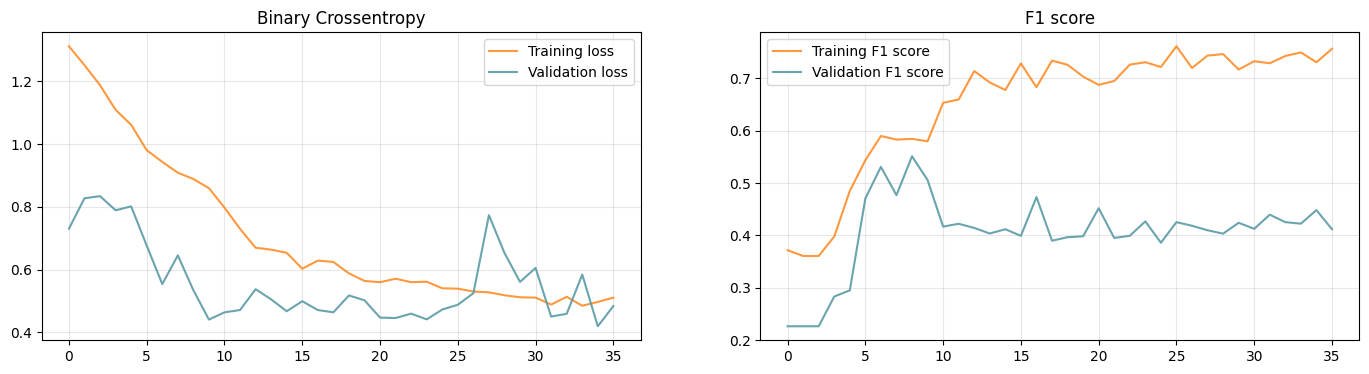

In [ ]:
# Geting the epoch index with the highest validation recall
best_epoch = np.argmax(history['val_recall'])
fig, axes = plt.subplots(1, 2, figsize=(17,4))

axes[0].plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
axes[0].plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
axes[0].set_title('Binary Crossentropy')
axes[0].legend()
axes[0].grid(alpha=.3)

axes[1].plot(history['f1score'], label='Training F1 score', alpha=.8, color='#ff7f0e')
axes[1].plot(history['val_f1score'], label='Validation F1 score', alpha=.9, color='#5a9aa5')
axes[1].set_title('F1 score')
axes[1].legend()
axes[1].grid(alpha=.3)

Computing the confusion matrix and defining the values that will be contained in the confusion matrix plot.

In [ ]:
cf_matrix = (confusion_matrix(y_val_window, y_val_pred_best, labels=[0, 1], sample_weight=None) / len(y_val_window) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(f'Accuracy:\t{accuracy_score(y_val_window,y_val_pred_best):.3f}')
print(f'Recall:\t\t{recall_score(y_val_window, y_val_pred_best):.3f}')
print(f'Precision:\t{precision_score(y_val_window, y_val_pred_best):.3f}')
print(f'F1score:\t{f1_score(y_val_window, y_val_pred_best):.3f}')

# Print the confusion matrix values and percentages
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.896
Recall:		0.483
Precision:	0.636
F1score:	0.549
True Neg:	83.33%
False Pos:	3.60%
False Neg:	6.76%
True Pos:	6.31%


Plotting the confusion matrix.

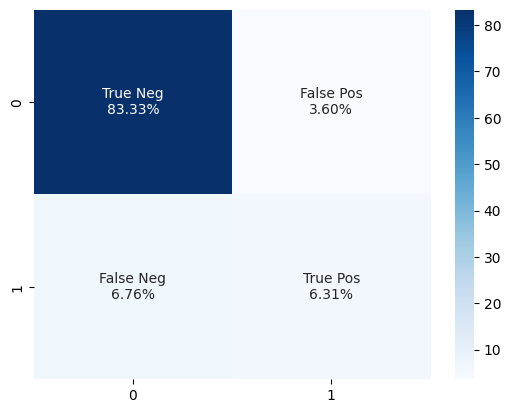

In [ ]:
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The following cell was used to save in a <code>log.txt</code> file the architecture and results of each tested model.

In [ ]:
# Storing the performance of different models in a log.txt file

original_stdout = sys.stdout

with open('log.txt', 'a') as log_file:
    # Redirect standard output to log file
    sys.stdout = log_file

    # Print LSTM model summary
    LSTM_model.summary()

    # Print accuracy, recall, precision, and F1 score
    print(f'Accuracy:\t{accuracy_score(y_val_window, y_val_pred_best):.3f}')
    print(f'Recall:\t\t{recall_score(y_val_window, y_val_pred_best):.3f}')
    print(f'Precision:\t{precision_score(y_val_window, y_val_pred_best):.3f}')
    print(f'F1score:\t{f1_score(y_val_window, y_val_pred_best):.3f}')

    # Print variables and their values
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')

    print('\n\n\n')

    # Restore original standard output
    sys.stdout = original_stdout

### Autoencoder

An autoencoder can be trained on a dataset containing normal, non-anomalous financial data. During training, the model learns to encode the input data into the latent space and decode it back to reconstruct the original data accurately. Once trained, the autoencoder can be used to reconstruct new data samples. If a new sample deviates significantly from the original data and results in a high reconstruction error, it may indicate an anomaly. By setting a threshold on the reconstruction error, anomalies can be detected based on deviations from the normal data distribution. Once the threshold is set, the reconstruction error of a time step can be converted into a probability by using the sigmoid function (centered in the threshold). In this way, the model output is the probability for each time step to be classified as an anomaly.

There are a large number of possibile architectures which could work as an autoencoder (e.g. fully connected autoencoder, LSTM autoencoder, convolutional autoencoder, transformer autoencoder). The architecture that worked best in this case was the **convolutional autoencoder** architecture.

With this architecture it was possible to use 1D convolutional filters and max pooling layers trying to exploit and learn the temporal correlation between different time steps. The filters are designed to act *feature-wise*, in the sense that they compute the correlation between different time steps of a feature and not the correlation between different features in a time step.

In [ ]:
# This function creates training widows of dimension W made only of normal data
def build_Autoencoder_samples(x, y, W=52):

    # INPUT:
    # x    : numpy array of training samples (e.g. x_train.to_numpy())
    # y    : numpy array of training labels (e.g. y_train.to_numpy())
    # W    : window dimension of the new training samples (default is 52, it should
    #        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # x_new: numpy array of new training samples split into windows

    x_norm = x[y==0]

    samples = x_norm.shape[0]
    features = x_norm.shape[1]

    indexes = np.arange(0, samples-W+1, 1)

    # defining the shape of the output data tensor
    x_new = np.empty((len(indexes), W, features))

    # inserting the windows into the new data vector through looping and indexing

    for i, j in enumerate(indexes):
        x_new[i] = x_norm[j:j+W]

    return x_new


# This function creates validation widows of dimension W made of normal and validation data
# The only difference with respect to previous function is that with this function the anomalies are not removed
def build_Autoencoder_test_samples(x, W=52):

    # INPUT:
    # x    : numpy array of training samples (e.g. x_train.to_numpy())
    # W    : window dimension of the new training samples (default is 52, it should
    #        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # x_new: numpy array of new training samples split into windows

    x_copy = np.copy(x)

    samples = x_copy.shape[0]
    features = x_copy.shape[1]

    indexes = np.arange(0, samples-W+1, 1)

    # defining the shape of the output data tensor
    x_new = np.empty((len(indexes), W, features))

    # inserting the windows into the new data vector through looping and indexing

    for i, j in enumerate(indexes):
        x_new[i] = x_copy[j:j+W]

    return x_new


# This function calculates the average reconstruction errors related to each validation time step
def build_true_errors(reconstruction_errors, W=52):

    # reconstruction_errors: numpy array of reconstruction errors related to validation samples (the output of the network)
    # W                    : window dimension of the new training samples (default is 52, it should
    #                        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # true_errors          : numpy array with length equal to the number of validation time steps
    #                        containing the average reconstruction error for each time step

    # Reshape the reconstruction errors to match the desired shape
    reshaped_errors = reconstruction_errors.reshape((reconstruction_errors.shape[0], reconstruction_errors.shape[1]))
    # Initialize arrays for storing true errors and counts
    true_errors = np.zeros(reconstruction_errors.shape[0]+W-1)
    counts = np.copy(true_errors)

    for i in range(reconstruction_errors.shape[0]):
        # Accumulate reconstruction errors over a sliding window of size W
        true_errors[i:i+W] += reshaped_errors[i]
        # Keep track of the number of errors accumulated in each window
        counts[i:i+W] += 1
    # Calculate the average errors within each window
    true_errors = true_errors / counts
    return true_errors


# This function computes the value of the reconstruction error threshold which maximizes the F1 score on the validation set
def find_threshold(errors, labels, upper=4, lower=0, eps=0.01):

    # INPUT:
    # errors   : numpy array containing the average reconstruction error
    #            for each time step (output of build_true_errors function)
    # labels   : array containing the labels associated to each time step
    # upper    : upper limit for the threshold value
    # lower    : lower limit for the threshold value
    # eps      : value of the threshold increment

    # OUPUT:
    # threshold: value of the threshold that maximizes the f1 score on the validation set
    # f1       : value of the maximum achieved f1 score

    f1 = 0
    threshold = lower
    temp_labels = np.empty(labels.shape)

    for i in np.arange(lower, upper, eps):
        # Assign labels based on the error threshold
        temp_labels[errors>=i] = 1
        temp_labels[errors<i] = 0
        # Update the best threshold and F1 score if the current F1 score is higher
        if (f1_score(labels, temp_labels)>f1):
            f1 = f1_score(labels, temp_labels)
            threshold = i

    return threshold, f1


# This function transforms the reconstruction errors array into an array of probabilities by applying the sigmoid function
def build_probabilities(errors, threshold):

    # INPUT:
    # errors       : numpy array containing the average reconstruction error
    #                for each time step (output of build_true_errors function)
    # threshold    : value of the threshold that maximizes the f1 score on the validation set

    # OUPUT:
    # probabilities: probability numpy array obtained by applying the sigmoid function to errors array

    # Define the base of the natural logarithm (e)
    e = 2.71828
    # Define the scaling factor to control the sigmoid function
    scaling_factor = -3
    # Transform the errors using the sigmoid function
    # The sigmoid function maps the errors to the range [0, 1]
    # The scaling factor adjusts the steepness of the sigmoid curve
    # A higher scaling factor makes the curve steeper, leading to sharper probabilities
    # A lower scaling factor makes the curve flatter, resulting in smoother probabilities
    probabilities = 1 / (1 + np.power(e, scaling_factor*(errors - threshold)))

    return probabilities

Building the samples for network training. <code>x_val_auto</code> and <code>x_test_auto</code> are both created from <code>x_val</code>, but the former does not contain anomalies and it is used to evaluate the validation loss during training, whereas the latter contains anomalies and it is used to compute reconstruction errors.

In [ ]:
x_train_auto = build_Autoencoder_samples(x_train, y_train)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_train_auto = x_train_auto.reshape(x_train_auto.shape + (1, ))

x_val_auto = build_Autoencoder_samples(x_val, y_val)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_val_auto = x_val_auto.reshape(x_val_auto.shape + (1, ))

x_test_auto = build_Autoencoder_test_samples(x_val)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_test_auto = x_test_auto.reshape(x_test_auto.shape + (1, ))

Defining the Convolutional Autoencoder architecture.

In [ ]:
def build_Conv_Autoencoder(input_shape):

    # INPUTS:
    # input_shape: shape of the input samples

    # OUTPUTS:
    # model      : Autoencoder keras model with specified architecture

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Defining the number of filters and the filter size for each layer
    FILTERS_1 = 3
    FILTERS_2 = 5
    FILTERS_3 = 15
    KERNEL_SIZE_1 = (15, 1)
    KERNEL_SIZE_2 = (8, 1)
    KERNEL_SIZE_3 = (3, 1)
    POOL_SIZE = (2, 1)

    # encoder part of the autoencoder consisting in two (convolutional + max pooling) modules
    encoder_conv_1 = tfkl.Conv2D(filters=FILTERS_1, kernel_size=KERNEL_SIZE_1, padding='same', activation='relu', name='EncoderConv1')(input_layer)
    encoder_mp_1 = tfkl.MaxPooling2D(pool_size=POOL_SIZE, name='EncoderMP1')(encoder_conv_1)
    encoder_conv_2 = tfkl.Conv2D(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, padding='same', activation='relu', name='EncoderConv2')(encoder_mp_1)
    encoder_mp_2 = tfkl.MaxPooling2D(pool_size=POOL_SIZE, name='EncoderMP2')(encoder_conv_2)

    # reduced representation layer of the autoencoder
    middle_conv = tfkl.Conv2D(filters=FILTERS_3, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu', name='MiddleConv2')(encoder_mp_2)

    # decoder part of the autoencoder consisting in two unpooling layers with a batch normalization layer in between
    decoder_conv_2 = tfkl.Conv2DTranspose(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, strides=POOL_SIZE, padding='same', activation='relu', name='DecoderConv2')(middle_conv)
    decoder_bn_2 = tfkl.BatchNormalization(name='BatchNorm2')(decoder_conv_2)
    output_layer = tfkl.Conv2DTranspose(filters=1, kernel_size=KERNEL_SIZE_1, strides=POOL_SIZE, padding='same', activation='relu', name='Output')(decoder_bn_2)

    # Defining the model specifying input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compiling the model with mean squared error loss (since it is a sort of regression problem) and Adam optimizer
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.legacy.Adam())

    return model

In [ ]:
# Defining the shape of the samples
input_shape = x_train_auto.shape[1:]

# Building Autoencoder model and printing the architecture
Autoencoder_model = build_Conv_Autoencoder(input_shape)
Autoencoder_model.summary(line_length = 100)

Model: "model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 Input (InputLayer)                          [(None, 52, 9, 1)]                      0              
                                                                                                    
 EncoderConv1 (Conv2D)                       (None, 52, 9, 3)                        48             
                                                                                                    
 EncoderMP1 (MaxPooling2D)                   (None, 26, 9, 3)                        0              
                                                                                                    
 EncoderConv2 (Conv2D)                       (None, 26, 9, 5)                        125            
                                                                            

Training the model.

In [ ]:
epochs = 500
batch_size = 32

# Defining the EarlyStopping callback (monitoring the f1score) to prevent overfitting and to restore the best weights
callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]

# Shuffling training and validation data
x_train_auto = shuffle(x_train_auto, random_state = seed)
x_val_auto = shuffle(x_val_auto, random_state = seed)

history = Autoencoder_model.fit(
    x = x_train_auto,
    y = x_train_auto,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_val_auto, x_val_auto),
    callbacks = callbacks,
).history

Epoch 1/500
20/20 [==============================] - 1s 36ms/step - loss: 0.9086 - val_loss: 0.7087
Epoch 2/500
20/20 [==============================] - 1s 27ms/step - loss: 0.7581 - val_loss: 0.7026
Epoch 3/500
20/20 [==============================] - 1s 26ms/step - loss: 0.7319 - val_loss: 0.6965
Epoch 4/500
20/20 [==============================] - 1s 26ms/step - loss: 0.7140 - val_loss: 0.6858
Epoch 5/500
20/20 [==============================] - 1s 26ms/step - loss: 0.6958 - val_loss: 0.6754
Epoch 6/500
20/20 [==============================] - 1s 26ms/step - loss: 0.6789 - val_loss: 0.6620
Epoch 7/500
20/20 [==============================] - 1s 26ms/step - loss: 0.6659 - val_loss: 0.6445
Epoch 8/500
20/20 [==============================] - 1s 26ms/step - loss: 0.6467 - val_loss: 0.6196
Epoch 9/500
20/20 [==============================] - 1s 26ms/step - loss: 0.6265 - val_loss: 0.5936
Epoch 10/500
20/20 [==============================] - 1s 27ms/step - loss: 0.6105 - val_loss: 0.5775

Plotting the training and validation losses as a function of the number of epochs.

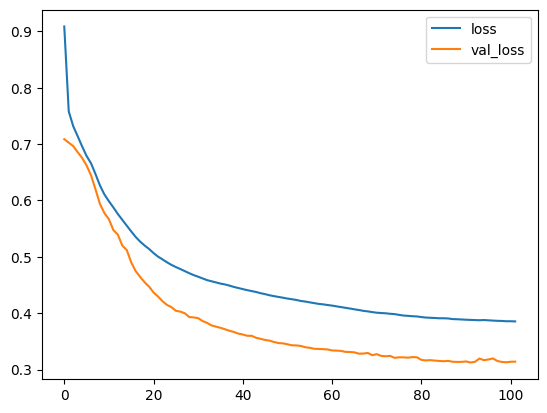

In [ ]:
plotLine = ['loss', 'val_loss']
plt.plot(history[plotLine[0]][0:])
plt.plot(history[plotLine[1]][0:])
plt.legend(plotLine)
plt.show()

- Defining the reconstruction error of a time step as a mean squared error: they are computed as the mean of the squared difference between the true values of the features of a time step and the predicted values;
- Using <code>build_true_errors</code> to get a vector containing the average reconstruction error for each sample;
- Using <code>find_threshold</code> on the reconstruction errors just computed to find the optimal threshold and F1 scores;
- Using <code>build_probabilities</code> to compute the probability for each time step to be classified as an anomaly starting from the reconstruction errors vector and the optimal threshold.

In [ ]:
reconstruction_errors = np.mean(np.power(x_test_auto - Autoencoder_model.predict(x_test_auto), 2), axis=2)
true_errors = build_true_errors(reconstruction_errors)

best_threshold_Autoencoder, f1_score_Autoencoder = find_threshold(true_errors, y_val)
res_autoencoder = build_probabilities(true_errors, best_threshold_Autoencoder)

print(f"Best threshold: {best_threshold_Autoencoder}")
print(f"Best F1: {f1_score_Autoencoder}")

6/6 [==============================] - 0s 17ms/step
Best threshold: 0.8200000000000001
Best F1: 0.5454545454545454


Plotting the results of the autoencoder model.

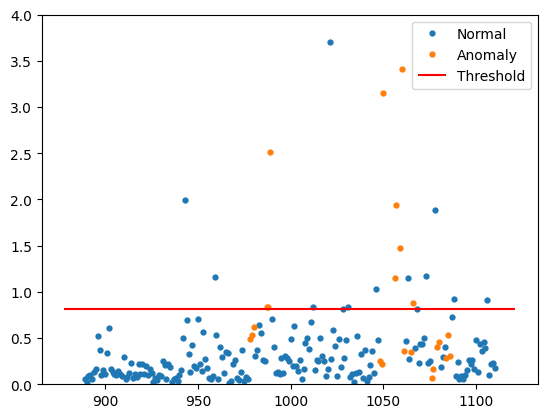

In [ ]:
errors_df = pd.DataFrame({'Y_test': y_val,'Score': true_errors})
groups = errors_df.groupby('Y_test')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Score, marker='o', ms=3.5, linestyle='', label= "Anomaly" if name == 1 else "Normal")

ax.hlines(best_threshold_Autoencoder, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim((0, 4))
ax.legend()

plt.show()

Computing the confusion matrix and defining the values that will be contained in the confusion matrix plot.

In [ ]:
y_val_pred_auto = np.empty(res_autoencoder.shape)
y_val_pred_auto[res_autoencoder>=0.5] = 1
y_val_pred_auto[res_autoencoder<0.5] = 0
cf_matrix = (confusion_matrix(y_val, y_val_pred_auto, labels=[0, 1], sample_weight=None) / len(y_val_window) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(f'Accuracy:\t{accuracy_score(y_val,y_val_pred_auto):.3f}')
print(f'Recall:\t\t{recall_score(y_val, y_val_pred_auto):.3f}')
print(f'Precision:\t{precision_score(y_val, y_val_pred_auto):.3f}')
print(f'F1score:\t{f1_score(y_val, y_val_pred_auto):.3f}')

# Print the confusion matrix values and percentages
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.887
Recall:		0.517
Precision:	0.577
F1score:	0.545
True Neg:	81.98%
False Pos:	4.95%
False Neg:	6.31%
True Pos:	6.76%


Plotting the confusion matrix.

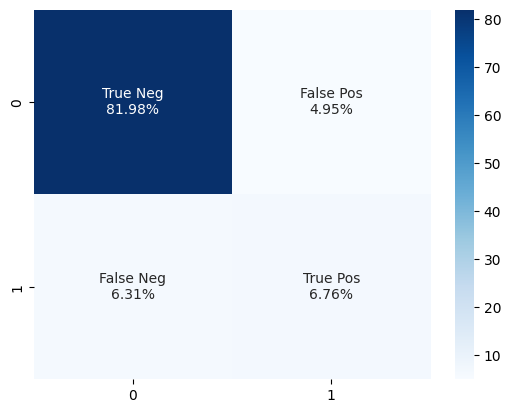

In [ ]:
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Copula

COPOD is an outlier detection algorithm that draws inspiration from copulas to model the distribution of multivariate data. It begins by constructing an empirical copula, which is then utilized to estimate the tail probabilities of each data point. This allows for the determination of the level of "extremeness" for each point. One of the key advantages of COPOD is that it is parameter-free, meaning it does not require manual parameter tuning. Additionally, it is highly interpretable and computationally efficient, making it a valuable tool for outlier detection.

In [ ]:
# separating input data from labels
x_train_copula = train_df.drop(labels = 'Y', axis = 1).to_numpy()
x_val_copula = val_df.drop(labels = 'Y', axis = 1).to_numpy()
y_train_copula = train_df['Y'].to_numpy()
y_val_copula = val_df['Y'].to_numpy()

In [ ]:
# Delete anomalies from training sets
X_train = np.delete(x_train_copula, np.where(y_train == 1)[0], axis=0)
y_train = np.delete(y_train_copula, np.where(y_train == 1)[0], axis=0)


In [ ]:
# Get standard normally distributed data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_val = std_scaler.transform(x_val_copula)

In [ ]:
# COPULA fit
clf = COPOD()
clf.fit(X_train)

y_train_scores = clf.decision_function(X_train)                                  # scores

# Get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_                                                       # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_                                            # raw outlier scores

# Get the prediction on the test data
cop_pred = clf.predict(X_val)                                                    # outlier labels (0 or 1)
cop_scores = clf.decision_function(X_val)                                        # outlier scores


Remark: It is important to note that the score generated by COPOD does not directly represent the probability of a data point being an outlier. Instead, it serves as a relative measure, indicating how likely the point is to be an outlier compared to other points in the dataset. A higher score implies a greater likelihood of the point being an outlier. Therefore, the magnitude of the score provides valuable insight into the level of deviation from the norm for each data point.

Threshold calibration

In [ ]:
# This function computes the following metrics: precision, recall anf f1 score
def confusion_metrics(y_test_pred, y_test):

    # INPUTS:
    # y_test_pred  : model prediction results comming from a test set [here, it is array of 0,1]
    # y_test       : real data of the test test

    # OUTPUTS:
    # precision, recall and f1 score

    tp = np.sum((y_test_pred == 1) & (y_test == 1))                               # true positive
    fp = np.sum((y_test_pred == 1) & (y_test == 0))                               # false positive
    fn = np.sum((y_test_pred == 0) & (y_test == 1))                               # false negative
    precision = tp / (tp + fp)                                                    # precision
    recall = tp / (tp + fn)                                                       # recall
    F1 = 2 * precision * recall / (precision + recall)                            # F1 score

    return precision,recall,F1

In [ ]:
# The following function returns f1 score of a method
def compute_F1(y_test_pred, y_test):

    # INPUTS:
    # y_test_pred  : model prediction results comming from a test set [here, it is array of 0,1]
    # y_test       : real data of the test test

    # OUTPUTS:
    # f1 score

    precision, recall, F1 = confusion_metrics(y_test_pred, y_test)

    return F1

In [ ]:
threshold = np.arange(min(cop_scores), max(cop_scores), 0.01)                    # range of discretized threshold

best_F1 = 0                                                                      # fictional value to enter the if clause (below)
error = 0.05                                                                     # allowed error

for thres in threshold:
    for i in range(0,len(y_val)):
        cop_pred[i] = cop_scores[i]> thres                                        # update test prediction values [values must be 0 or 1]

    F1 = compute_F1(cop_pred, y_val)                                              # updated f1 score

    if F1 > best_F1:
      best_F1 = F1                                                               # the highest value of f1 score
      predictions = cop_pred
      threshold_calibrated = thres                                               # optimal threshold [it maximizes the f1 score]

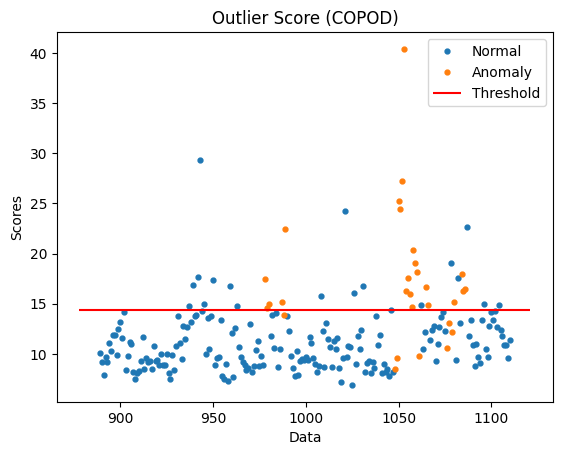

In [ ]:
# Visualization tool

conf_results = pd.DataFrame({'Y_pred': cop_pred,'Y_test': y_val,'Score': cop_scores})
groups = conf_results.groupby('Y_test')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Score, marker='o', ms=3.5, linestyle='', label= "Anomaly" if name == 1 else "Normal")

ax.hlines(threshold_calibrated, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Outlier Score (COPOD)")
plt.ylabel("Scores")
plt.xlabel("Data")
plt.show();

Commenting on the *Outlier Score (COPOD)* graph, we can observe that the model identifies scores above the red line as anomalies. The blue and orange dots represent normal or anomalous data points, with their distinction determined by the real label assigned to each time instance.

In [ ]:
# metrics considering the optimal threshold [the biggest f1 score]

for i in range(0,len(y_val)):
  cop_pred[i] = cop_scores[i]> threshold_calibrated

precision, recall, F1 = confusion_metrics(cop_pred, y_val)
print("Precision: ", precision)
print("Recall: ",recall)
print("F1 Score: ",F1)

best_threshold_Copula = threshold_calibrated
f1_score_Copula = F1

Precision:  0.55
Recall:  0.7586206896551724
F1 Score:  0.6376811594202898


### Final model: Ensamble Averaging

Now that different models were built, trained on the training set and validated on the validation set, the ensamble of models is defined. The ensamble of models predicts a probability as the average of the probabilities predicted by each model, weighted by the goodness of each model (in terms of F1 score).

New test data was downloaded from Bloomberg (2021-2023 period), but for this period labels were not available. To test the goodness of the final model, the predicted labels of the ensamble average are used to control the behavior (in terms of investment risk propensity) of a toy portfolio.

In [ ]:
# This function downloads and returns market data from yfinance
def get_market_prices(start_date, end_date, asset_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download [it must be a string: ex. '^GSPC']

  # OUTPUT:
  # prices      : array with prices of asset_name at market's closure time


    market_data = yf.download(asset_name, start=start_date, end=end_date, interval='1wk') # download
    prices = market_data['Close'].to_numpy()                                              # array with the closure prices

    return prices



# This function converts data downloaded from yfinance in USD
def USD_conversion(start_date, end_date, asset_values, forex_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_values: prices in the original currency
  # forex_name  : name of the currency-conversione to download. IT MUST be USD vs other currency (and NOT viceversa) [it must be a string]

  # OUTPUT:
  # prices      : array with USD prices of asset_name at market closure time


  coversion_rates = get_market_prices(start_date, end_date, forex_name)          # get currency converison rate

  prices = asset_values / coversion_rates                                        # asset price in USD

  return prices

In [ ]:
# defining the start and end dates of the data we want to download
start_date = '2021-04-23'
end_date = '2023-05-12'

# reading dataframe from excel file
df_test = pd.read_excel('FinancialMarketDataTest.xlsx', 'Sheet1')

# adding missing data
gold_test =  get_market_prices(start_date,end_date,'GC=F')
df_test['XAU BGNL'] = gold_test

# converting to US dollars
df_test['MXCN'] = USD_conversion(start_date, end_date, df_test['MXCN'], 'HKD=X')
df_test['MXEU'] = USD_conversion(start_date, end_date, df_test['MXEU'], 'EUR=X')
df_test['MXJP'] = USD_conversion(start_date, end_date, df_test['MXJP'], 'JPY=X')

# adding sp_gold column to dataframe
df_test = add_sp_gold(df_test)
df_test.drop(labels = 'XAU BGNL', axis = 1, inplace = True)

returns_labels = ['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXUS', 'VIX', 'GT10']
returns_features = df_test[returns_labels].to_numpy()

# calculating the returns as the differences between feature at time t and time t-1, divided by feature at time t-1 (times 100)
returns_test = pd.DataFrame(np.diff(returns_features, axis=0) / returns_features[:-1, :]) * 100

# restoring the original column names and indexes
returns_test.columns = returns_labels
returns_test.index = df_test.index[1:]

df_test = pd.concat([returns_test, df_test[['SP_GOLD', 'ECSURPUS']].iloc[1:]], axis=1)

# building the final test set by applying same scaling of the training set
dummy, x_test = scaler(train_df, df_test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Standard scaling was applied


Building the test set probability vector for **SVM**. Since the model does not allow to output a probability but only binary labels $\left\{0,1\right\}$, we decided to scale anomaly values to 0.75 and normal values to 0.25. In this way the impact of SVM model on the ensamble average would be reduced and more similar to other models.

In [ ]:
# SVM
y_test_svm_temp = svm_rbf.predict(x_test)
y_test_svm = np.empty(y_test_svm_temp.shape)
y_test_svm[y_test_svm_temp == 1] = 0.75
y_test_svm[y_test_svm_temp == 0] = 0.25

Building the test set probability vector for **LSTM**.

In [ ]:
# LSTM
x_test_LSTM, _ = build_LSTM_samples(pd.concat([x_val.iloc[-49:], x_test], axis=0), np.empty(x_test.shape[1]))
y_test_LSTM = LSTM_model.predict(x_test_LSTM).reshape(-1)

4/4 [==============================] - 0s 8ms/step


Building the test set probability vector for **Autoencoder**.

In [ ]:
# Autoencoder
x_test_Autoencoder = build_Autoencoder_test_samples(x_test)
x_test_Autoencoder = x_test_Autoencoder.reshape(x_test_Autoencoder.shape + (1, ))
test_errors = np.mean(np.power(x_test_Autoencoder - Autoencoder_model.predict(x_test_Autoencoder), 2), axis=2)
true_test_errors = build_true_errors(test_errors)
y_test_Autoencoder = build_probabilities(true_test_errors, best_threshold_Autoencoder)

2/2 [==============================] - 0s 10ms/step


Building the test set probability vector for **Copula**.

In [ ]:
# Copula
x_test_copula = df_test.to_numpy()
x_test_copula = std_scaler.transform(x_test_copula)
cop_pred = clf.predict(x_test_copula)
cop_scores = clf.decision_function(x_test_copula)
e = 2.71828
y_test_copula = 1 / (1 + np.power(e, -2*(cop_scores - best_threshold_Copula)))

Computing the sum of the F1 scores achieved by each model.

In [ ]:
sum_f1_scores = f1_score_SVM + f1_score_LSTM + f1_score_Autoencoder + f1_score_Copula

Computing the probability assigned by the ensamble of models as the average of the probabilities predicted by each model, weighted by the goodness of each model (in terms of F1 score).

In [ ]:
y_test = (y_test_svm * f1_score_SVM +
          y_test_LSTM * f1_score_LSTM +
          y_test_Autoencoder * f1_score_Autoencoder +
          y_test_copula * f1_score_Copula) / sum_f1_scores

# Portfolio

## **An application: a toy portfolio**

In [ ]:
# This function downloads from yahoo finance the prices of an asset for a given time window
def get_market_prices(start_date, end_date, asset_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download [it must be a string: ex. '^GSPC']

  # OUTPUT:
  # prices      : array with prices of asset_name at market's closure time


    market_data = yf.download(asset_name, start=start_date, end=end_date, interval='1wk') # download
    prices = market_data['Close'].to_numpy()                                              # array with the closure prices

    return prices

In [ ]:
# This function converts in USD the prices of an asset traded on a different currency
def get_prices_USD(start_date, end_date, asset_name, forex_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download. It is not traded in USD [it must be a string: ex. '^GSPC']
  # forex_name  : name of the currency-conversione to download. IT MUST be USD vs other currency (and NOT viceversa) [it must be a string]

  # OUTPUT:
  # prices      : array with USD prices of asset_name at market's closure time


  asset_prices_non_USD = get_market_prices(start_date, end_date, asset_name)     # assets download
  coversion_rates = get_market_prices(start_date, end_date, forex_name)          # forex

  prices = asset_prices_non_USD / coversion_rates                                # asset price in USD

  return prices


In [ ]:
# This function retrives the risk label by means of specific thresholds passed as input parameters
def get_labels(thresh_up, thresh_down,y_test_scores):

  # INPUTS:
  # thresh_up         : upper threshold [it separates medium from high risk class]
  # thresh_down       : lower threshhold [it separates medium from low risk class]
  # y_test_scores     : model outputs to be converted into risk labels

  # OUTPUT:
  # market_risk_labels :  list with  a risk label for each time instant


  market_risk_labels=[]

  for p in y_test_scores:
    if p >= thresh_up:                                                           # high risk condition
        market_risk_labels.append('High')
    elif p >= thresh_down:                                                       # medium risk condition
        market_risk_labels.append('Medium')
    elif p < thresh_down:
        market_risk_labels.append('Low')                                         # low risk contition

  return market_risk_labels

 For the sake of simplicity and to enhance our understanding of the performance of our anomaly detection analysis, we have considered a small basket of assets as components of a toy portfolio. It is important to note that while the financial principle of diversification has not been completely disregarded, it has been taken into consideration to some extent. We have included ETFs and financial indices that provide explanatory insights. The portfolio is exposed to both stock and bond markets, and it also includes commodities.

Portfolio composition:


1.   Stock Market
    *   S&P 500 [^GSPC]

    *   Invesco EURO STOXX 50 UCITS ETF [SX5E.SW]
2.   Bond Market
    *   Vanguard EUR Eurozone Government Bond UCITS ETF [VETY.L]

    *   Vanguard Total Bond Market Index Fund [VBTLX]
3.   Commodities
    *    S&P GSCI Index [^SPGSCI]

    *  Crude Oil Jul 23 [CL=F]



Another simplification we made, albeit unrealistic, is that we did not consider any transaction fees or changes.

In [ ]:
start_date = '2021-04-20'                                                        # starting point
end_date = '2023-05-12'                                                          # ending point


#Equity                                                                          # Equity asset of our toy portfolio [in USD]
n_equity = 2
sp500 = get_market_prices(start_date, end_date, '^GSPC')
invesco_euro = get_prices_USD(start_date, end_date, 'SX5E.SW', 'EUR=X')          # prices in EUR, converted in USD

#Bonds                                                                           # bond market part of our portfolio [in USD]
n_bonds = 2
etf_eu_bond = get_prices_USD(start_date, end_date, 'VETY.L', 'GBP=X')            # prices in GBP, converted in USD
vanguard_bond = get_market_prices(start_date, end_date, 'VBTLX')

# Commodities                                                                    # commodities involved in our portfolio [in USD]
n_commodities = 2
commodity_index = get_market_prices(start_date, end_date, '^SPGSCI')
oil = get_market_prices(start_date, end_date, 'CL=F')

ptf = [sp500, invesco_euro, etf_eu_bond, vanguard_bond, commodity_index, oil]    # list with all the weekly prices of the assets involved in our portfolio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimizing portfolio allocation weights involves assessing the risk levels associated with various asset classes or investment options. The allocation strategy employed will be contingent upon the risk tolerance and investment objectives of the individual or institution involved.

However, a possible percentage partition among equity, bonds, and commodities in a real portfolio could have the following structure:

1. Equity (stocks):

    *   Conservative: 20-40%
    *   Moderate: 40-60%
    *   Aggressive: 60-80%


2.   Bonds: they are often considered more stable investment instruments and can be used to balance risk in portfolio allocation.
    *   Conservative: 40-60%
    *   Moderate:  30-50%
    *   Aggressive: 20-40%


3.   Commodities: they can provide diversification and protection against inflation.
    *   Conservative:  5-10%
    *   Moderate:  10-15%
    *   Aggressive: 15-20%





We have considered a fictional one-to-one correspondance between an investor's risk exposure and the market risk labels

In [ ]:
# This function computes the returns of the assets of a given portfolio
def compute_returns(ptf):

  # INPUT:
  # ptf   : weekly prices of all the asset in a portfolio [it is a list]

  # OUPUT:
  # returns: weekly returns of all the assets in ptf [dimension: num_asset* num_instances]

    ptf_array = np.array(ptf)                                                    # initialization
    returns = np.zeros(ptf_array.shape)

    for index in range(ptf_array.shape[0]):
        asset = ptf_array[index]
        returns[index,:-1] = np.diff(asset) / asset[:-1]                         # weekly returns

    return returns

In [ ]:
# The function selects the appropriated weights allocation based on how anomalous the day is believed to be
def get_allocation(market_risk_labels):

  # INPUT:
  # market_risk_labels : list with  a risk label for each time instant

  # OUTPUT:
  # allocation_list    : list with the weekly allocation (weights) of a toy portfolio, based on the market risk labels

  allocation_list=[]

  for index in range(len(market_risk_labels)):
    if market_risk_labels[index]=='Low':                                         # low risk condition
      allocation_list.append([0.65, 0.15,0.2])
    elif market_risk_labels[index]=='Medium':                                    # medium risk condition
       allocation_list.append([0.5, 0.35,0.15])
    else : allocation_list.append([0.25, 0.65, 0.10])                            # high risk condition

  return allocation_list



Arbitrary thresholds have been set on the "probability" output from the ensambled model, in order to differenciate the three macro risk-frameworks.
The risk_label list obtained has been used to simulate our Toy-Portfolio P&L, based on the instructions defined above.
A specific weight allocation has been chosen for every market risk-level situation:


1. Low risk market:

    *   Equity: 65%
    *   Bonds: 15%
    *   Commodities: 20%


2. Medium risk market:

    *   Equity: 50%
    *   Bonds: 35%
    *   Commodities: 15%


3. High risk market:

    *   Equity: 25%
    *   Bonds: 65%
    *   Commodities: 10%



In [ ]:
# TOY PORTFOLIO

pnl = []                                                                         # Profit and Loss list
portfolio_value = 1                                                              # Notional (starting) portfolio value

lower_threshold = 0.4                                                           # fixing thresholds for our ensambled model:
upper_threshold = 0.6                                                           # risk labels are here assigned in the testing framework

market_risk_labels = get_labels(upper_threshold, lower_threshold, y_test)        # market risk label values in [start_date, end_date]
returns = compute_returns(ptf)                                                   # weekly returns for each assest (of ptf)
ptf_allocation=get_allocation(market_risk_labels)                                # weights associated to labels

for i in range(1,len(market_risk_labels)):

  equity_returns_tot= returns[0][i]+ returns[1][i]
  equity_pnl=ptf_allocation[i][0]* equity_returns_tot* 1/n_equity *portfolio_value        # Profit and Loss at time i within the stock market

  bond_returns_tot= returns[2][i]+ returns[3][i]
  bond_pnl=ptf_allocation[i][1]* bond_returns_tot* 1/n_bonds *portfolio_value             # Profit and Loss at time i within the bond market

  commodities_returns_tot= returns[4][i]+ returns[5][i]
  commodities_pnl=ptf_allocation[i][2]* commodities_returns_tot* 1/n_commodities *portfolio_value  # Profit and Loss at time i within commodities


  total_pnl=equity_pnl + bond_pnl + commodities_pnl                              # weekly PnL
  portfolio_value += total_pnl                                                   # cumulative Profit and Loss

  pnl.append(portfolio_value)

As comparison model for the ensambled one, the Copula model alone has been used to provide another portfolio simulation along the same time-frame.
The Copula, indeed, appeared to outperform every other model in terms of F1 Score.

In [ ]:
# COPOD Portfolio
market_risk_labels_copod = get_labels(lower_threshold, upper_threshold, y_test_copula)
ptf_allocation_copod=get_allocation(market_risk_labels_copod)

pnl_copod=[]
portfolio_value=1

for i in range(1,len(market_risk_labels_copod)):

  equity_returns_tot= returns[0][i]+ returns[1][i]
  equity_pnl=ptf_allocation_copod[i][0]* equity_returns_tot* 1/n_equity *portfolio_value        # Profit and Loss at time i within the stock market

  bond_returns_tot= returns[2][i]+ returns[3][i]
  bond_pnl=ptf_allocation_copod[i][1]* bond_returns_tot* 1/n_bonds *portfolio_value            # Profit and Loss at time i within the bond market

  commodities_returns_tot= returns[4][i]+ returns[5][i]
  commodities_pnl=ptf_allocation_copod[i][2]* commodities_returns_tot* 1/n_commodities *portfolio_value  # Profit and Loss at time i within commodities


  total_pnl=equity_pnl + bond_pnl + commodities_pnl                              # weekly PnL
  portfolio_value += total_pnl                                                   # cumulative Profit and Loss

  pnl_copod.append(portfolio_value)

Three portfolios are taken as benchmarks for low, medium and high risk market labels, respectively. They mantain a fixed asset allocation over time.

In [ ]:
# The function computes the profit and loss of a portfolio with unit nominal value and fixed asset allocation over time
def pnl_benchmark(returns,profile,n_equity,n_bonds,n_commodities):

  # INPUTS:
  # returns       : weekly returns matrix (rows: time step, columns: asset type)
  # profile       : risk profile (low, medium,high) [as 'string']
  # n_equity      : number of equity assets in the portfolio
  # n_bonds       : number of bond assets in the portfolio
  # n_commodities : number of commodity assets in the portfolio

  # NOTE: the number of equity, bond, commodity assets must be specified for the model to EQUALLY weight each asset within its category.

  # OUTPUT:
  # pnl :  list with cumulative Profit and Loss over time

  pnl = []
  portfolio_value = 1

  for i in range(1,len(market_risk_labels)):

    if profile == 'Low':
      allocation = [0.65, 0.15,0.2]
    elif profile == 'Medium':
      allocation = [0.5, 0.35,0.15]
    elif profile == 'High':
      allocation = [0.25, 0.65, 0.10]


    equity_returns_tot= returns[0][i]+ returns[1][i]
    equity_pnl=allocation[0]* equity_returns_tot* 1/n_equity *portfolio_value        # Profit and Loss at time i within the stock market

    bond_returns_tot= returns[2][i]+ returns[3][i]
    bond_pnl=allocation[1]* bond_returns_tot* 1/n_bonds *portfolio_value             # Profit and Loss at time i within the bond market

    commodities_returns_tot= returns[4][i]+ returns[5][i]
    commodities_pnl=allocation[2]* commodities_returns_tot* 1/n_commodities *portfolio_value  # Profit and Loss at time i within commodities


    total_pnl=equity_pnl + bond_pnl + commodities_pnl                              # weekly PnL
    portfolio_value += total_pnl                                                   # cumulative Profit and Loss

    pnl.append(portfolio_value)

  return pnl

In [ ]:
# LOW RISK PORTFOLIO
pnl_bench_low = pnl_benchmark(returns, 'Low', n_equity, n_bonds, n_commodities)
# MEDIUM RISK PORTFOLIO
pnl_bench_med = pnl_benchmark(returns, 'Medium', n_equity, n_bonds, n_commodities)
# HIGH RISK PORTFOLIO
pnl_bench_high = pnl_benchmark(returns, 'High', n_equity, n_bonds, n_commodities)

The evolution of the simulated portfolios (ensambled and copula) and the three benchmarks are plotted to compare performances over time.
All portfolios start with the same notional value (=1); however, at each following time step the notional value used in the pnl computation is different between each portfolio due to previous fluctuations. This leads to a different P&L scale for the following weeks.

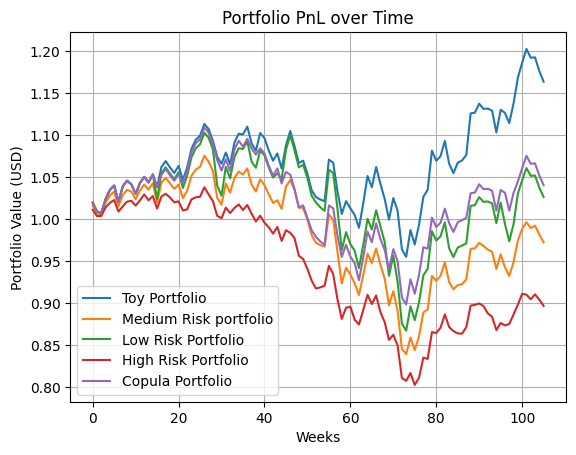

In [ ]:
plt.plot(pnl)
plt.title('Portfolio PnL over Time')
plt.xlabel('Weeks')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.plot(pnl_bench_med)
plt.plot(pnl_bench_low)
plt.plot(pnl_bench_high)
plt.plot(pnl_copod)
plt.legend(['Toy Portfolio', 'Medium Risk portfolio', 'Low Risk Portfolio', 'High Risk Portfolio', 'Copula Portfolio'])

plt.show()

Comment on *Portfolio PnL over Time* graph:
As expected, the three fixed portfolio benchmarks follow the same trend and their values are just rescaled.

Despite following the best performing method, the copula portfolio does not outperform its competitors. It seems to replicate the evolution of a low risk portfolio.

On the other hand, our toy portfolio outperformes on the market. It seems that the voting scheme provides market insights undetected by COPOD and this could be the reason why the toy portfolio beats the copula one. Moreover, this proves that time (or even dependance over time, if any) should be taken into consideration in an anomaly detection analysis. That is the main difference and trade off between a more statistical-like approach, as COPOD, and artificial neural networks.